In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.linalg import sqrtm
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.29MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.93MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



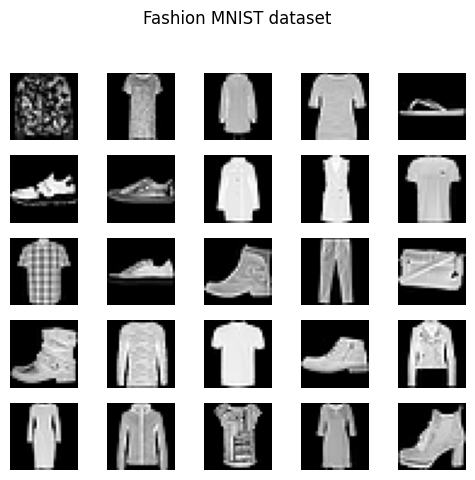

In [8]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images[:25]

plt.figure(figsize=(5, 5))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.imshow(images[i].reshape((28,28)), cmap='gray')
  plt.axis('off')

plt.suptitle(f"Fashion MNIST dataset")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [4]:
class GAN(nn.Module):
  def __init__(self, latent_dim):
    super(GAN, self).__init__()
    self.generator = nn.Sequential(
      nn.Unflatten(1,(latent_dim,1,1)),
      nn.ConvTranspose2d(latent_dim, 128, 7, stride=1, padding = 0),
      nn.BatchNorm2d(128),
      nn.ReLU(True),
      nn.ConvTranspose2d(128, 64, 4, stride=2, padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU(True),
      nn.ConvTranspose2d(64, 1, 4, stride=2, padding = 1),
      nn.Sigmoid()
    )
    self.discriminator = nn.Sequential(
      nn.Conv2d(1, 64, 4, stride=2, padding=1),
      nn.LeakyReLU(0.2, True),
      nn.Conv2d(64, 128, 4, stride=2, padding=1),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, True),
      nn.Conv2d(128, 256, 4, stride=2, padding=1),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, True),
      nn.Conv2d(256, 512, 3, stride=1, padding=0),
      nn.Flatten(),
      nn.Linear(512, 1),
      nn.Sigmoid()
    )

  def generate(self, z):
    return self.generator(z)

  def discriminate(self, img):
    return self.discriminator(img)

In [9]:
def plot_generator(noise, epoch):
  with torch.no_grad():
    generated_images = gan.generate(noise)
    generated_images = generated_images.view(25, 28, 28).cpu().numpy()

    plt.figure(figsize=(5, 5))
    for i in range(25):
      plt.subplot(5, 5, i + 1)
      plt.imshow(generated_images[i], cmap='gray')
      plt.axis('off')

    plt.suptitle(f"Generated Images in Epoch {epoch}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [19]:
latent_dim = 100
lr = 0.0002
gan = GAN(100).to(device)

optimizer_G = optim.Adam(gan.generator.parameters(), lr=lr)
optimizer_D = optim.Adam(gan.discriminator.parameters(), lr=lr/5)

adversarial_loss = nn.BCELoss()


Epoch [1/100], d_loss: 0.2854714095592499, g_loss: 2.241806983947754, D(x): 0.820522665977478, D(G(z)): 0.12683698534965515
Epoch [2/100], d_loss: 0.541363000869751, g_loss: 1.856776475906372, D(x): 0.7687172889709473, D(G(z)): 0.4225059449672699
Epoch [3/100], d_loss: 0.36449792981147766, g_loss: 1.4946839809417725, D(x): 0.7195632457733154, D(G(z)): 0.17981936037540436
Epoch [4/100], d_loss: 0.37588968873023987, g_loss: 2.4956185817718506, D(x): 0.7107518911361694, D(G(z)): 0.17438149452209473
Epoch [5/100], d_loss: 0.5995305776596069, g_loss: 2.067617893218994, D(x): 0.6984413862228394, D(G(z)): 0.4283519387245178
Epoch [6/100], d_loss: 0.6868311762809753, g_loss: 1.5725934505462646, D(x): 0.4941027760505676, D(G(z)): 0.3778409957885742
Epoch [7/100], d_loss: 0.5772165656089783, g_loss: 1.766455888748169, D(x): 0.4336286187171936, D(G(z)): 0.1701289564371109
Epoch [8/100], d_loss: 0.49781930446624756, g_loss: 1.4364986419677734, D(x): 0.5574740767478943, D(G(z)): 0.18463467061519623

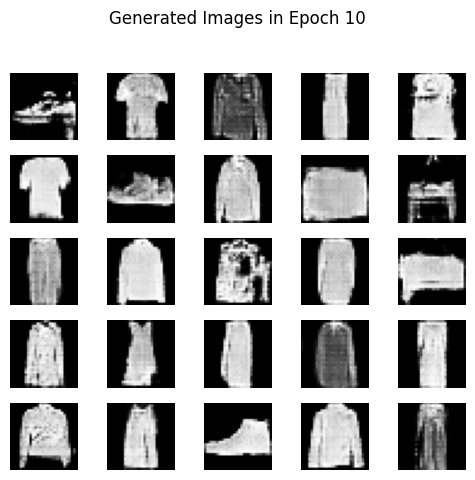

FID Score: 31.88897313112452
Epoch [10/100], d_loss: 0.4229106903076172, g_loss: 2.0530147552490234, D(x): 0.7309638261795044, D(G(z)): 0.2957531809806824
Epoch [11/100], d_loss: 1.0393534898757935, g_loss: 1.475373387336731, D(x): 0.23252679407596588, D(G(z)): 0.2692694664001465
Epoch [12/100], d_loss: 0.4160512685775757, g_loss: 1.4534006118774414, D(x): 0.7819186449050903, D(G(z)): 0.2610298991203308
Epoch [13/100], d_loss: 0.4871601462364197, g_loss: 1.4576122760772705, D(x): 0.5890153646469116, D(G(z)): 0.238270565867424
Epoch [14/100], d_loss: 0.5651007890701294, g_loss: 2.1133358478546143, D(x): 0.5599992275238037, D(G(z)): 0.2587559223175049
Epoch [15/100], d_loss: 0.3030826151371002, g_loss: 2.8558666706085205, D(x): 0.7721480131149292, D(G(z)): 0.1506994366645813
Epoch [16/100], d_loss: 0.4654550552368164, g_loss: 1.2129638195037842, D(x): 0.6755343675613403, D(G(z)): 0.27880364656448364
Epoch [17/100], d_loss: 0.36378729343414307, g_loss: 3.090397357940674, D(x): 0.715926647

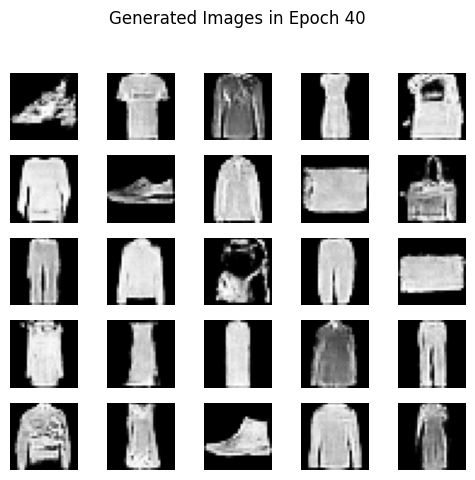

FID Score: 7.812391113954544
Epoch [40/100], d_loss: 0.2566164433956146, g_loss: 2.561802387237549, D(x): 0.7415540218353271, D(G(z)): 0.04106394946575165
Epoch [41/100], d_loss: 0.4549202620983124, g_loss: 3.533097743988037, D(x): 0.5117470026016235, D(G(z)): 0.09196697175502777
Epoch [42/100], d_loss: 0.2573215365409851, g_loss: 1.2624788284301758, D(x): 0.8443310260772705, D(G(z)): 0.06879335641860962
Epoch [43/100], d_loss: 0.32151445746421814, g_loss: 1.1488919258117676, D(x): 0.8923147320747375, D(G(z)): 0.18145833909511566
Epoch [44/100], d_loss: 0.23492801189422607, g_loss: 2.0508663654327393, D(x): 0.8491889238357544, D(G(z)): 0.05758807808160782
Epoch [45/100], d_loss: 0.3839835226535797, g_loss: 3.5379505157470703, D(x): 0.9781540632247925, D(G(z)): 0.22647203505039215
Epoch [46/100], d_loss: 0.23941944539546967, g_loss: 3.704479694366455, D(x): 0.808318555355072, D(G(z)): 0.061868153512477875
Epoch [47/100], d_loss: 0.2497822493314743, g_loss: 3.6071043014526367, D(x): 0.89

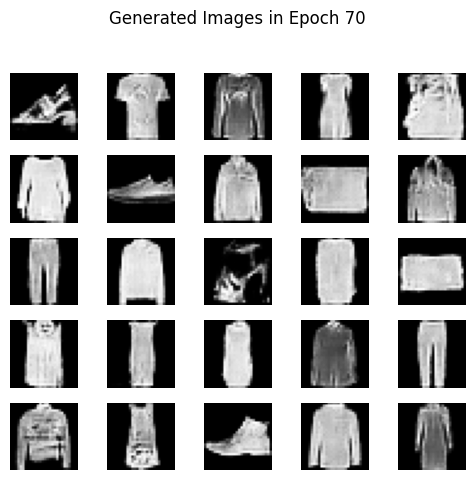

FID Score: 6.696743589891039
Epoch [70/100], d_loss: 0.20607708394527435, g_loss: 3.121670961380005, D(x): 0.8157104253768921, D(G(z)): 0.005328447557985783
Epoch [71/100], d_loss: 0.466438889503479, g_loss: 4.865573883056641, D(x): 0.426214337348938, D(G(z)): 0.0171328317373991
Epoch [72/100], d_loss: 0.2668158710002899, g_loss: 2.02644681930542, D(x): 0.9632794260978699, D(G(z)): 0.10785460472106934
Epoch [73/100], d_loss: 0.4021000266075134, g_loss: 3.82075834274292, D(x): 0.5444002151489258, D(G(z)): 0.012883473187685013
Epoch [74/100], d_loss: 0.24142558872699738, g_loss: 3.564150810241699, D(x): 0.72588050365448, D(G(z)): 0.011403370648622513
Epoch [75/100], d_loss: 0.18610839545726776, g_loss: 4.788507461547852, D(x): 0.8574531078338623, D(G(z)): 0.011885412037372589
Epoch [76/100], d_loss: 0.2839273512363434, g_loss: 2.4915521144866943, D(x): 0.6710095405578613, D(G(z)): 0.02017657645046711
Epoch [77/100], d_loss: 0.26548513770103455, g_loss: 2.479994773864746, D(x): 0.97023898

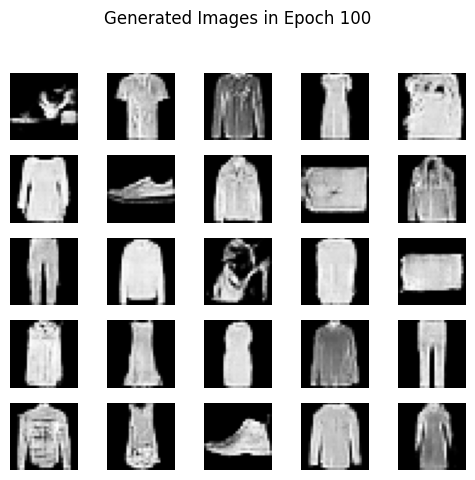

FID Score: 6.298465926704818
Epoch [100/100], d_loss: 0.24862365424633026, g_loss: 4.302257537841797, D(x): 0.7230799198150635, D(G(z)): 0.021335169672966003


In [20]:
real_losses = []
fake_losses = []
g_losses = []
fid_scores = []
EPOCHS = 100

fixed_noise = torch.randn(25, latent_dim, device=device)  # for evaluating while training

for epoch in range(EPOCHS):
  epoch_real_loss = 0
  epoch_fake_loss = 0
  epoch_g_loss = 0
  for i, (imgs, _) in enumerate(train_loader):
    gan.train()
    imgs = imgs.to(device)  # Move data to the device (CPU or GPU)

    # discriminator
    real = torch.ones((imgs.shape[0], 1), device=device) * 0.9
    fake = torch.zeros((imgs.shape[0], 1), device=device)

    real_score = gan.discriminate(imgs)
    real_loss = adversarial_loss(real_score, real)
    real_losses.append(real_loss.item())
    epoch_real_loss += real_loss.item()

    z = torch.randn(imgs.shape[0], latent_dim, device=device)
    fake_images = gan.generate(z)
    fake_score = gan.discriminate(fake_images.detach())
    fake_loss = adversarial_loss(fake_score, fake)
    fake_losses.append(fake_loss.item())
    epoch_fake_loss += fake_loss.item()

    d_loss = (real_loss + fake_loss)/2

    optimizer_D.zero_grad()
    d_loss.backward()
    optimizer_D.step()

    # generator
    z = torch.randn(imgs.shape[0], latent_dim, device=device)
    fake_images = gan.generate(z)
    g_loss = adversarial_loss(gan.discriminate(fake_images), real)
    g_losses.append(g_loss.item())
    epoch_g_loss += g_loss.item()

    optimizer_G.zero_grad()
    g_loss.backward()
    optimizer_G.step()

  if epoch in [9,39,69,99]:
    gan.eval()
    plot_generator(fixed_noise, epoch + 1)
    fid = fid_score(10000, gan, test_loader, fmnist_classifier)
    fid_scores.append(fid)
    print(f"FID Score: {fid}")



  print(f"Epoch [{epoch+1}/{EPOCHS}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}, D(x): {real_score.mean().item()}, D(G(z)): {fake_score.mean().item()}")


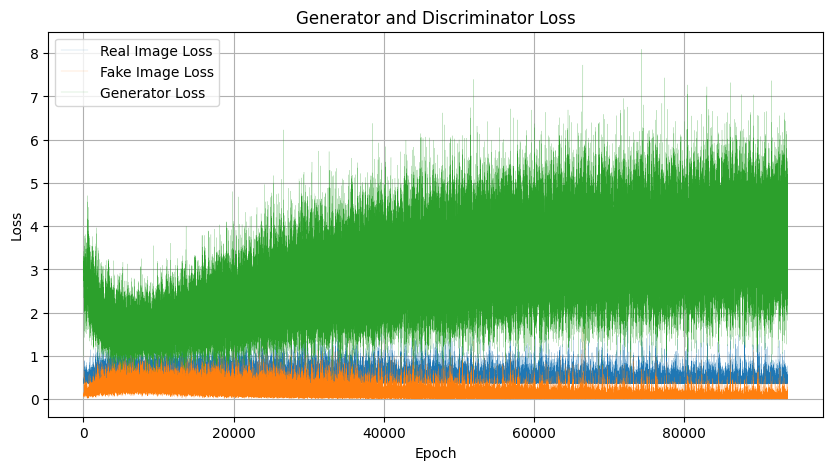

In [32]:


plt.figure(figsize=(10, 5))
plt.plot(real_losses, label='Real Image Loss', linewidth=0.1)
plt.plot(fake_losses, label='Fake Image Loss', linewidth=0.1)
plt.plot(g_losses, label='Generator Loss', linewidth=0.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Loss')
plt.grid(True)
plt.show()


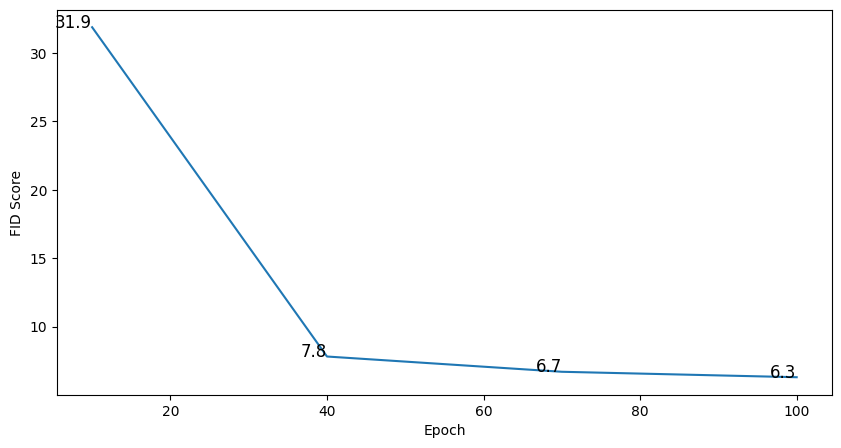

In [30]:
epoch = [10, 40, 70, 100]
plt.figure(figsize=(10, 5))
plt.plot(epoch,fid_scores, label='FID score')
for epoch, fid_score in zip(epoch, fid_scores):
   plt.text(epoch, fid_score, f'{fid_score:.1f}', fontsize=12, ha='right')
plt.xlabel('Epoch')
plt.ylabel('FID Score')
plt.show()

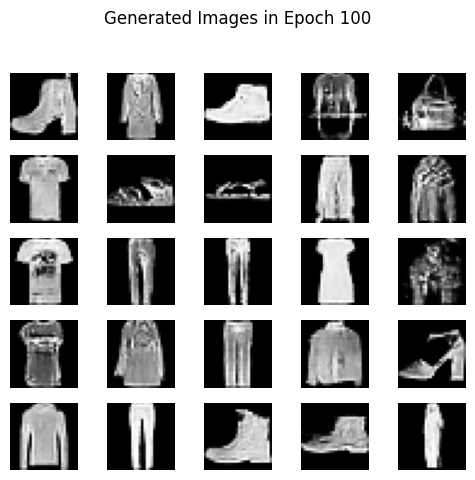

In [25]:
gan.eval()
plot_generator(torch.randn(25, latent_dim, device=device), 100)

In [17]:
#@title Fashion MNIST Classifier (it was trained 30 epochs, you see only the last 10 epochs)

import torch
import torch.nn as nn
import torch.nn.functional as F

class FMNISTClassifier(nn.Module):
    def __init__(self):
        super(FMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, 1, padding=1)

        self.fc1 = nn.Linear(512 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        y = self.fc4(self.get_features(x))
        return y

    def get_features(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv5(x))
        x = x.view(-1, 512 * 1 * 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        features = x
        return features



fmnist_classifier = FMNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fmnist_classifier.parameters(), lr=0.09)

EPOCHS = 10
for epoch in range(EPOCHS):
  fmnist_classifier.train()
  running_loss = 0.0
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    outputs = fmnist_classifier(data)
    loss = criterion(outputs, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * data.size(0)

  epoch_loss = running_loss / len(train_loader.dataset)
  print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}')



Epoch 1/10, Loss: 0.1023
Epoch 2/10, Loss: 0.0953
Epoch 3/10, Loss: 0.0882
Epoch 4/10, Loss: 0.0807
Epoch 5/10, Loss: 0.0746
Epoch 6/10, Loss: 0.0722
Epoch 7/10, Loss: 0.0642
Epoch 8/10, Loss: 0.0623
Epoch 9/10, Loss: 0.0565
Epoch 10/10, Loss: 0.0518


In [10]:
def calculate_fid(real_features, fake_features):
  miu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
  miu2, sigma2 = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

  miu_distance = np.sum((miu1 - miu2) ** 2.0)
  rad_s1s2 = sqrtm(sigma1.dot(sigma2))
  rad_s1s2 = rad_s1s2.real  # removes imaginary parts

  fid = miu_distance + np.trace(sigma1 + sigma2 - 2.0 * rad_s1s2)
  return fid


def get_features(dataloader, classifier, num_samples):
  classifier.eval()
  features = []
  count = 0
  with torch.no_grad():
    for images in dataloader:
      if count >= num_samples:
          break
      images = images[0].to(device)
      outputs = classifier.get_features(images)
      outputs = outputs.cpu().numpy()
      if count + outputs.shape[0] > num_samples:
          outputs = outputs[:num_samples - count]
      features.append(outputs)
      count += outputs.shape[0]
  return np.concatenate(features, axis=0)

def generate_fake_images(model, num_images, batch_size):
  images = []
  with torch.no_grad():
    for _ in range(num_images // batch_size):
      noise = torch.randn(batch_size, latent_dim, device=device)
      fake_images = model.generate(noise).detach().cpu()
      images.append(fake_images)
  return torch.cat(images)

def fid_score(num_samples, model, test_loader, classifier):
  fake_images = generate_fake_images(model, num_samples, batch_size=64)
  fake_dataset = TensorDataset(fake_images)
  fake_loader = DataLoader(fake_dataset, batch_size=64, shuffle=False)
  real_features = get_features(test_loader, classifier, num_samples)
  fake_features = get_features(fake_loader, classifier, num_samples)
  fid_score = calculate_fid(real_features, fake_features)
  return fid_score
